Logistic Regression best params: {'clf__C': 0.1} | CV AUC: 0.687
Random Forest best params: {'clf__max_depth': 5, 'clf__n_estimators': 100} | CV AUC: 0.686
XGBoost best params: {'clf__max_depth': 3, 'clf__n_estimators': 50} | CV AUC: 0.686
              precision    recall  f1-score   support

       False       0.61      0.39      0.48      4516
        True       0.68      0.84      0.75      6840

    accuracy                           0.66     11356
   macro avg       0.65      0.62      0.61     11356
weighted avg       0.65      0.66      0.64     11356

Test ROC AUC: 0.687


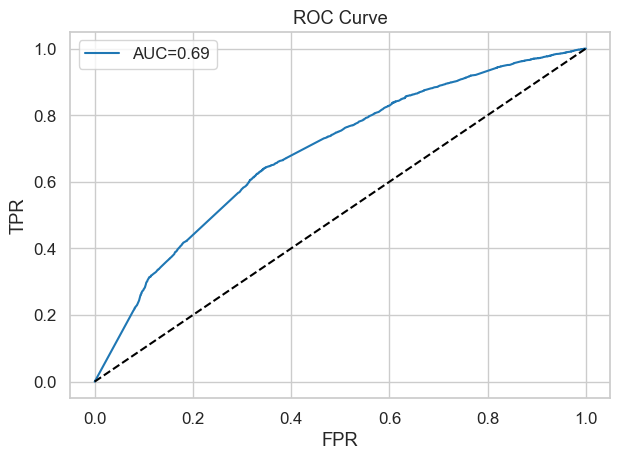

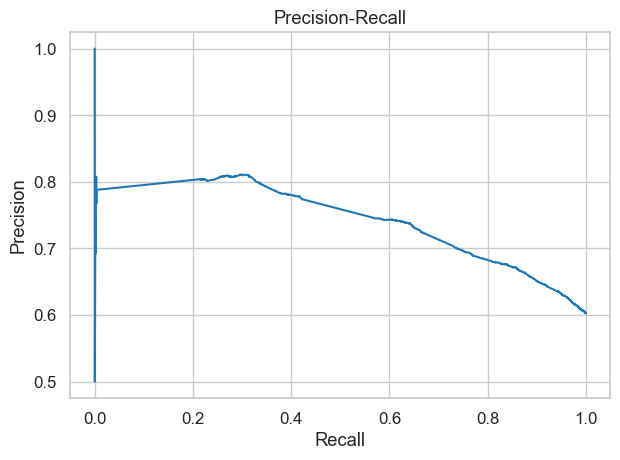

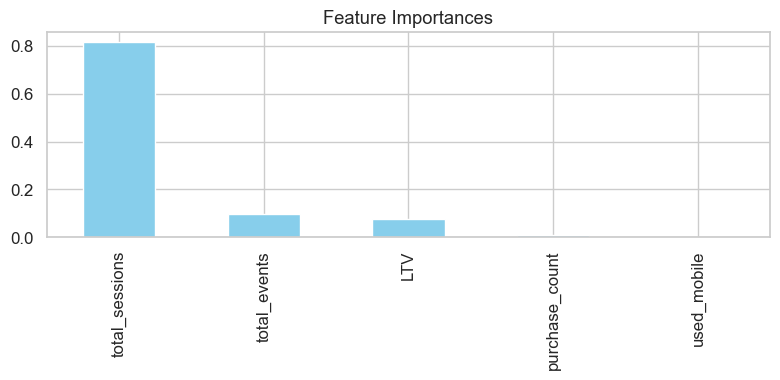

SHAP analysis failed: TreeExplainer.__init__() got an unexpected keyword argument 'check_additivity'


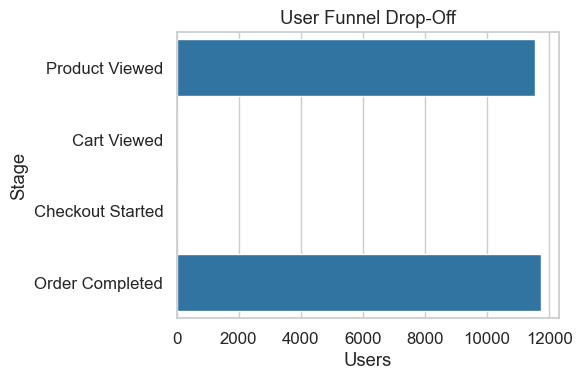

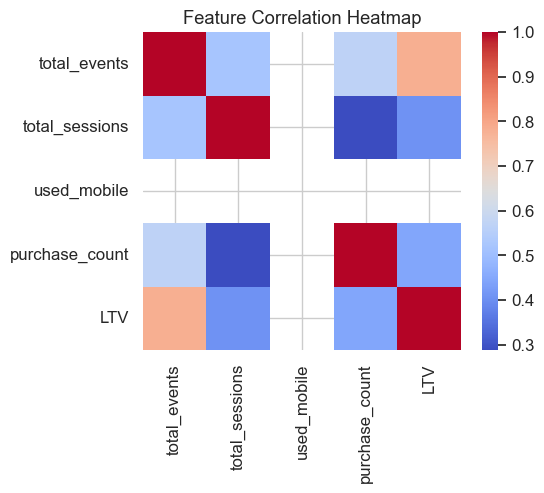

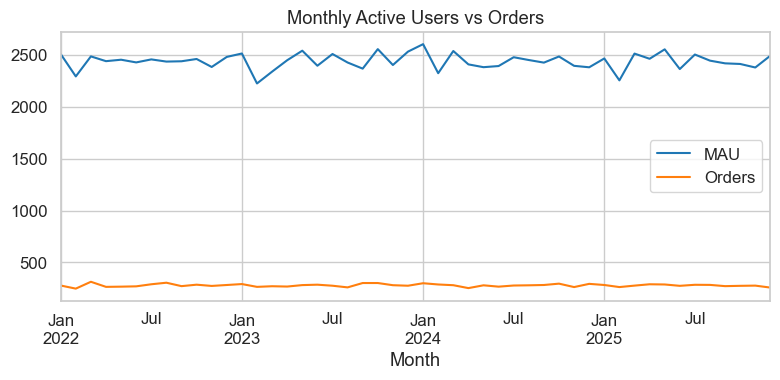

In [11]:
# Imports and configuration
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import json_normalize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.pipeline import Pipeline
try:
    import shap
    have_shap = True
except ImportError:
    have_shap = False
    print("SHAP library not found; skipping SHAP interpretability.")
from scipy.stats import ttest_ind

# Use seaborn for plotting aesthetics
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.1)

# 1. Data Ingestion: Load CSV files and combine into one DataFrame
csv_files = [
]
all_dfs = []
for fp in csv_files:
    try:
        df = pd.read_csv(fp, skiprows=1)
    except Exception as e:
        print(f"Could not read {fp}: {e}")
        continue
    df['source_file'] = fp
    all_dfs.append(df)
combined = pd.concat(all_dfs, ignore_index=True)
combined['timestamp'] = pd.to_datetime(combined['timestamp'], errors='coerce')
combined['session_user'] = combined['userId'].fillna(combined['anonymousId'])

# 2. JSON Column Parsing

def robust_parse_json(val):
    if isinstance(val, dict): return val
    if pd.isnull(val) or val in ["", "null", "None", "nan"]: return None
    try: return json.loads(val)
    except: 
        try: return eval(val)
        except: return None

if 'properties' in combined.columns:
    combined['properties'] = combined['properties'].apply(robust_parse_json)
if 'context' in combined.columns:
    combined['context'] = combined['context'].apply(robust_parse_json)
    ctx = json_normalize(combined['context'])
    combined = pd.concat([combined.drop(columns='context'), ctx], axis=1)

# 3. Session Modeling
combined = combined.sort_values(['session_user','timestamp'])
combined['time_diff'] = combined.groupby('session_user')['timestamp'].diff().dt.total_seconds()
combined['new_session'] = combined['time_diff'].isna() | (combined['time_diff'] > 1800)
combined['session_id'] = combined.groupby('session_user')['new_session'].cumsum()

# 4. Feature Engineering
cutoff = pd.to_datetime("2025-04-01")
last_evt = combined.groupby('userId')['timestamp'].max()
combined['churned'] = combined['userId'].map(lambda uid: last_evt.get(uid, pd.Timestamp(0)) < cutoff)

uf = combined.groupby('userId').agg(
    total_events=('event','count'),
    total_sessions=('session_id','nunique'),
    used_mobile=('source_file', lambda files: any('Mobile' in f for f in files))
).reset_index()

# purchase count
if 'event' in combined.columns:
    m = combined['event'].fillna('').str.contains('Order Completed', case=False)
    purch = combined.loc[m].groupby('userId').size().rename('purchase_count')
    uf = uf.merge(purch, on='userId', how='left').fillna({'purchase_count':0})

uf['churned'] = uf['userId'].map(lambda uid: bool(combined.loc[combined['userId']==uid,'churned'].iloc[0]))

# LTV
if 'properties' in combined.columns:
    combined['revenue'] = combined['properties'].apply(lambda p: p.get('price',0)*p.get('quantity',1) if isinstance(p,dict) else 0)
    ltv = combined.groupby('userId')['revenue'].sum().rename('LTV')
    uf = uf.merge(ltv, on='userId', how='left').fillna({'LTV':0})
else:
    uf['LTV'] = 0

# 5. Modeling Strategy
X = uf.drop(columns=['userId','churned'])
y = uf['churned']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    'Logistic Regression': (
        Pipeline([('clf', LogisticRegression(max_iter=1000))]),
        {'clf__C': [0.1, 1, 10]}
    ),
    'Random Forest': (
        Pipeline([('clf', RandomForestClassifier(random_state=42))]),
        {'clf__n_estimators': [50, 100], 'clf__max_depth': [5, 10]}
    ),
    'XGBoost': (
        Pipeline([('clf', XGBClassifier(eval_metric='logloss', random_state=42))]),
        {'clf__n_estimators': [50, 100], 'clf__max_depth': [3, 6]}
    )
}
best_estimators = {}
for name, (pipe, params) in models.items():
    grid = GridSearchCV(pipe, params, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid.fit(X, y)
    best_estimators[name] = grid.best_estimator_
    print(f"{name} best params: {grid.best_params_} | CV AUC: {grid.best_score_:.3f}")

# Final evaluation
model = best_estimators['Random Forest']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]
print(classification_report(y_test, preds))
print(f"Test ROC AUC: {roc_auc_score(y_test, proba):.3f}")

# 6. Results Interpretation
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.2f}");
plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.tight_layout(); plt.show()

prec, rec, _ = precision_recall_curve(y_test, proba)
plt.figure(); plt.plot(rec, prec); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall'); plt.tight_layout(); plt.show()

imp = pd.Series(model.named_steps['clf'].feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4)); imp.plot(kind='bar', color='skyblue'); plt.title('Feature Importances'); plt.tight_layout(); plt.show()

# SHAP interpretability
if have_shap:
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    Xt_num, Xe_num = X_train[numeric_cols], X_test[numeric_cols]
    try:
        explainer = shap.TreeExplainer(model.named_steps['clf'], Xt_num, check_additivity=False)
        sv = explainer.shap_values(Xe_num)
        shap.summary_plot(sv, Xe_num)
    except Exception as e:
        print(f"SHAP analysis failed: {e}")

# 7. Visualizations
# Funnel drop-off
stages = ['Product Viewed','Cart Viewed','Checkout Started','Order Completed']
counts = [combined['session_user'][combined['event'].fillna('').str.contains(s,case=False)].nunique() for s in stages]
plt.figure(figsize=(6,4))
sns.barplot(y='Stage', x='Users', data=pd.DataFrame({'Stage':stages,'Users':counts}), hue=None, palette=None, legend=False)
plt.title('User Funnel Drop-Off'); plt.tight_layout(); plt.show()

# Correlation heatmap
plt.figure(figsize=(6,5)); sns.heatmap(X.corr(), cmap='coolwarm', square=True); plt.title('Feature Correlation Heatmap'); plt.tight_layout(); plt.show()

# Timeline of MAU vs Orders
combined.set_index('timestamp', inplace=True)
monthly_users = combined['session_user'].resample('ME').nunique()
mask = combined['event'].fillna('').str.contains('Order Completed', case=False)
monthly_orders = combined.loc[mask, 'event'].resample('ME').count()
plt.figure(figsize=(8,4)); monthly_users.plot(label='MAU'); monthly_orders.plot(label='Orders')
plt.title('Monthly Active Users vs Orders'); plt.xlabel('Month'); plt.legend(); plt.tight_layout(); plt.show()

import json

product_rows = []

for idx, row in combined_all_years.iterrows():
    props = row.get('properties')
    
    # Try to parse props if it's a string
    if isinstance(props, str):
        # Convert single quotes to double quotes for JSON compliance
        props_json_str = props.replace("'", '"')
        try:
            props = json.loads(props_json_str)
        except Exception:
            continue

    # At this point, props is either a dict or None
    if isinstance(props, dict):
        # Products as a list in 'products'
        if 'products' in props and isinstance(props['products'], list):
            for product in props['products']:
                if isinstance(product, str):
                    # Same fix: convert single quotes to double quotes
                    product_json_str = product.replace("'", '"')
                    try:
                        product = json.loads(product_json_str)
                    except Exception:
                        continue
                if isinstance(product, dict):
                    rec = dict(product)
                    rec['year'] = row.get('year')
                    rec['timestamp'] = row.get('timestamp')
                    rec['userId'] = row.get('userId')
                    rec['anonymousId'] = row.get('anonymousId')
                    product_rows.append(rec)
        # Single product as dict at top level
        elif 'product_id' in props:
            rec = dict(props)
            rec['year'] = row.get('year')
            rec['timestamp'] = row.get('timestamp')
            rec['userId'] = row.get('userId')
            rec['anonymousId'] = row.get('anonymousId')
            product_rows.append(rec)

products_df = pd.DataFrame(product_rows)
print("✅ products_df shape:", products_df.shape)
print(products_df.head())


In [16]:
import pandas as pd
import numpy as np
import random
from faker import Faker
from datetime import timedelta

# Config
fake = Faker()
random.seed(42)
np.random.seed(42)
n_users = 5000

labubu_product = {
    "product_id": "prod_labubu",
    "name": "Labubu",
    "category": "Toys"
}
products = [
    labubu_product,
    *[
        {
            "product_id": f"prod_{i:04d}",
            "name": fake.word(),
            "category": random.choice(['Toys','Electronics','Home','Beauty'])
        }
        for i in range(1, 100)
    ]
]
campaigns = ["summer_sale", "labubu_drop_code", "winter_clearance", "influencer_push"]
browsers = ["Chrome", "Safari", "Edge", "Firefox"]
devices = ["iPhone 15", "Galaxy S23", "Pixel 8"]
oses_web = ["Windows", "MacOS", "Linux"]
oses_mobile = ["iOS", "Android"]
screens = ["Home", "Product Detail", "Cart", "Checkout", "Profile", "Deals", "Labubu Drop"]

# Utility
def make_session_id(user_id, idx):
    return f"{user_id}_sess{idx}"

def random_date(start, end):
    delta = end - start
    rand_days = random.randint(0, delta.days)
    rand_secs = random.randint(0, 86400)
    return start + pd.Timedelta(days=rand_days, seconds=rand_secs)

def ab_group():
    return random.choice(["A", "B"])

def set_if_val(d, k, v):
    if v is not None:
        d[k] = v

# Identify Event
def generate_identify(user_id, platform, ab_group, signup_time):
    traits = {
        "name": fake.name(),
        "email": fake.email(),
        "plan": random.choice(['free','plus','premium']),
        "logins": random.randint(1, 30),
        "experiment_id": "labubu_ab",
        "variation_id": ab_group
    }
    context = {
        "platform": platform,
        "session_id": make_session_id(user_id, 0),
        "os": random.choice(oses_web if platform == "web" else oses_mobile)
    }
    if platform == "web":
        context["browser"] = random.choice(browsers)
    if platform == "mobile":
        context["device_model"] = random.choice(devices)
    return {
        "anonymousId": fake.uuid4(),
        "userId": user_id,
        "timestamp": signup_time,
        "type": "identify",
        "traits": traits,
        "context": context
    }

# Page Event (web only)
def generate_page(user_id, ts, session_id, campaign, page_name="Home"):
    context = {
        "platform": "web",
        "browser": random.choice(browsers),
        "os": random.choice(oses_web),
        "session_id": session_id
    }
    set_if_val(context, "campaign", campaign)
    props = {
        "url": f"https://brandazon.com/{page_name.lower().replace(' ','_')}"
    }
    return {
        "anonymousId": fake.uuid4(),
        "userId": user_id,
        "timestamp": ts,
        "type": "page",
        "name": page_name,
        "properties": props,
        "context": context
    }

# Screen Event (mobile only)
def generate_screen(user_id, ts, session_id, campaign, screen_name="Home"):
    context = {
        "platform": "mobile",
        "device_model": random.choice(devices),
        "os": random.choice(oses_mobile),
        "app_version": f"{random.randint(1,5)}.{random.randint(0,9)}",
        "session_id": session_id
    }
    set_if_val(context, "campaign", campaign)
    props = {}
    if screen_name in ["Product Detail", "Labubu Drop"]:
        set_if_val(props, "product_id", labubu_product["product_id"])
        set_if_val(props, "category", labubu_product["category"])
    return {
        "anonymousId": fake.uuid4(),
        "userId": user_id,
        "timestamp": ts,
        "type": "screen",
        "name": screen_name,
        "properties": props,
        "context": context
    }

# Track Event (web or mobile)
def generate_track(user_id, ts, session_id, platform, ab_group, campaign, event_name, product=None, price=None, quantity=None, experiment=False):
    context = {
        "platform": platform,
        "session_id": session_id,
        "os": random.choice(oses_web if platform=="web" else oses_mobile)
    }
    if platform == "web":
        context["browser"] = random.choice(browsers)
    if platform == "mobile":
        context["device_model"] = random.choice(devices)
    set_if_val(context, "campaign", campaign)
    if experiment:
        context["experiment_id"] = "labubu_ab"
        context["variation_id"] = ab_group
    props = {}
    if event_name in ["Product Viewed", "Order Completed"]:
        if product:
            set_if_val(props, "product_id", product["product_id"])
            set_if_val(props, "name", product["name"])
            set_if_val(props, "category", product["category"])
        set_if_val(props, "price", price)
        set_if_val(props, "quantity", quantity)
    return {
        "anonymousId": fake.uuid4(),
        "userId": user_id,
        "timestamp": ts,
        "type": "track",
        "event": event_name,
        "properties": props,
        "context": context
    }

# Main Data Generation
events = []
start = pd.Timestamp('2023-01-01')
end = pd.Timestamp('2025-07-01')

for i in range(n_users):
    user_id = f"user_{i+1:06d}"
    signup = random_date(start, end - pd.Timedelta(days=90))
    user_ab = ab_group()
    platform = random.choices(["web", "mobile", "both"], [0.35,0.35,0.3])[0]
    platform_list = ["web","mobile"] if platform=="both" else [platform]
    # Identify (first session)
    events.append(generate_identify(user_id, random.choice(platform_list), user_ab, signup))

    n_sessions = random.randint(2, 8)
    for sess_idx in range(n_sessions):
        session_id = make_session_id(user_id, sess_idx)
        sess_date = signup + pd.Timedelta(days=random.randint(0, 90), minutes=random.randint(0, 1440))
        sess_platform = random.choice(platform_list)
        # Always start session with a page or screen event
        if sess_platform == "web":
            events.append(generate_page(user_id, sess_date, session_id, random.choice(campaigns), page_name="Home"))
        else:
            events.append(generate_screen(user_id, sess_date, session_id, random.choice(campaigns), screen_name="Home"))

        # Track: A/B test for Labubu, only group B gets exposed
        if user_ab == "B" and random.random() < 0.5:
            labubu_event_time = sess_date + pd.Timedelta(minutes=random.randint(1,15))
            events.append(generate_track(
                user_id, labubu_event_time, session_id, sess_platform, user_ab, "labubu_drop_code",
                event_name="Promotion Clicked", product=labubu_product, experiment=True
            ))
            # Higher chance to buy Labubu if exposed
            if random.random() < 0.6:
                events.append(generate_track(
                    user_id, labubu_event_time + pd.Timedelta(minutes=5), session_id, sess_platform, user_ab, "labubu_drop_code",
                    event_name="Order Completed", product=labubu_product, price=99.99, quantity=1, experiment=True
                ))
        # Typical commerce flow
        if random.random() < 0.7:
            prod = random.choice(products)
            pv_time = sess_date + pd.Timedelta(minutes=random.randint(1,20))
            events.append(generate_track(
                user_id, pv_time, session_id, sess_platform, user_ab, random.choice(campaigns),
                event_name="Product Viewed", product=prod
            ))
        if random.random() < 0.25:
            prod = random.choice(products)
            oc_time = sess_date + pd.Timedelta(minutes=random.randint(2,25))
            events.append(generate_track(
                user_id, oc_time, session_id, sess_platform, user_ab, random.choice(campaigns),
                event_name="Order Completed", product=prod, price=round(random.uniform(10,200),2), quantity=random.randint(1,3)
            ))
        # Secondary navigation
        if sess_platform == "web" and random.random() < 0.5:
            events.append(generate_page(user_id, sess_date + pd.Timedelta(minutes=10), session_id, random.choice(campaigns), page_name="Product"))
        if sess_platform == "mobile" and random.random() < 0.5:
            events.append(generate_screen(user_id, sess_date + pd.Timedelta(minutes=12), session_id, random.choice(campaigns), screen_name=random.choice(screens)))

print(f"Generated {len(events):,} events.")

# Convert to DataFrame and save
df = pd.DataFrame(events)
df.to_csv("brandazon_all_events.csv", index=False)
print("CSV generated: brandazon_all_events.csv")

Generated 77,085 events.
CSV generated: brandazon_all_events.csv
